# Multiclass Obesity risk Using Decision Trees

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Dropout, Dense, PReLU, ELU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

from xgboost import XGBClassifier

In [2]:
pd.set_option("display.max_columns", 35)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
#Seaborn settings for visualizations!
rc = {
    "axes.facecolor": "#f7f9fc",
    "figure.facecolor": "#f7f9fc",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

default_palette = 'YlOrRd'

sns.set(rc=rc)

## Import the dataset

In [4]:
df_train = pd.read_csv("../train.csv/train.csv")
df_test = pd.read_csv("../test.csv/test.csv")

In [5]:
print(f"The shape of the traning dataset is: {df_train.shape}")
print(f"The shape of the testing dataset is: {df_test.shape}")

The shape of the traning dataset is: (20758, 18)
The shape of the testing dataset is: (13840, 17)


In [6]:
from tabulate import tabulate
data = [
    ["FAVC", "Frequent consumption of high caloric food"],
    ["FCVC", "Frequency of consumption of vegetables"],
    ["NCP", "Number of main meals"],
    ["CAEC", "Consumption of food between meals"],
    ["CH20", "Consumption of water daily"],
    ["CALC", "Consumption of alcohol"],
    ["SCC", "Calories consumption monitoring"],
    ["FAF", "Physical activity frequency"],
    ["TUE", "Time using technology devices"],
    ["MTRANS", "Transportation used"]
]
headers = ["Abbreviation", "Full Form"]

table = tabulate(data, headers, tablefmt="pipe")
print(table)

| Abbreviation   | Full Form                                 |
|:---------------|:------------------------------------------|
| FAVC           | Frequent consumption of high caloric food |
| FCVC           | Frequency of consumption of vegetables    |
| NCP            | Number of main meals                      |
| CAEC           | Consumption of food between meals         |
| CH20           | Consumption of water daily                |
| CALC           | Consumption of alcohol                    |
| SCC            | Calories consumption monitoring           |
| FAF            | Physical activity frequency               |
| TUE            | Time using technology devices             |
| MTRANS         | Transportation used                       |


### Let's Vizualize the Data

In [7]:
colors = ["#4caba4", "#d68c78",'#a3a2a2','#ab90a0', '#e6daa3', '#6782a8', '#8ea677']

In [8]:
def showplot(column_name):
    values = df_train[column_name].value_counts()
    labels = values.index.tolist()

    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    ax.pie(
        values, 
        autopct="%1.1f%%", 
        textprops={"size":9, "color":"white", "fontweight":"bold"},
        colors=colors,
        wedgeprops=dict(width=0.35),
        startangle=80,
        pctdistance=0.85,
        labels=labels,
    )
    fig.suptitle(column_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

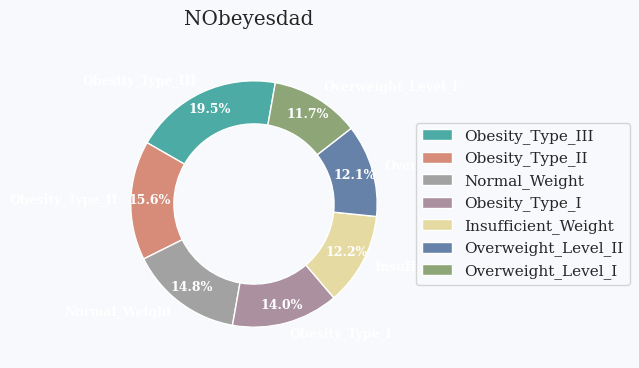

In [9]:
showplot("NObeyesdad")

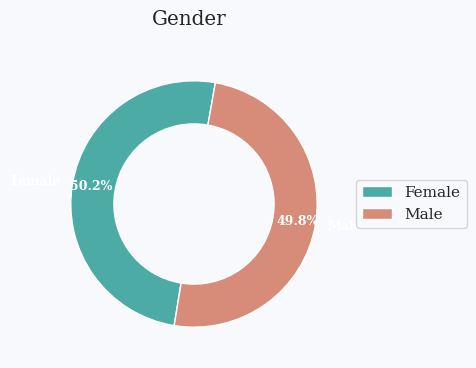

In [10]:
showplot("Gender")

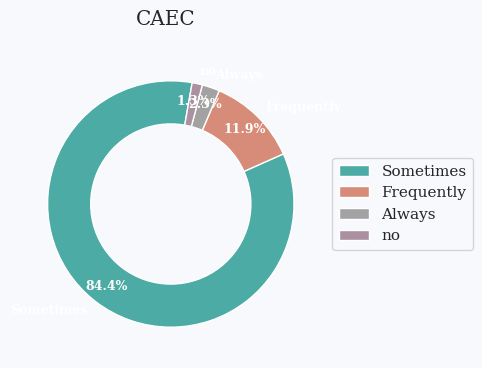

In [11]:
showplot('CAEC')

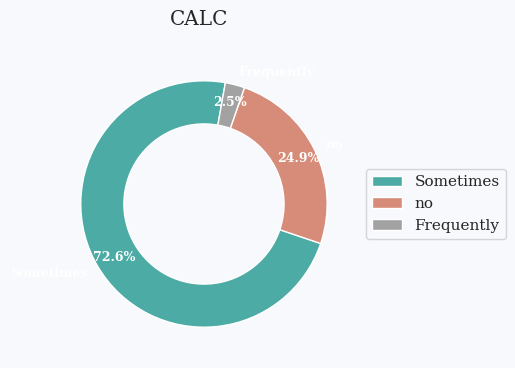

In [12]:
showplot("CALC")

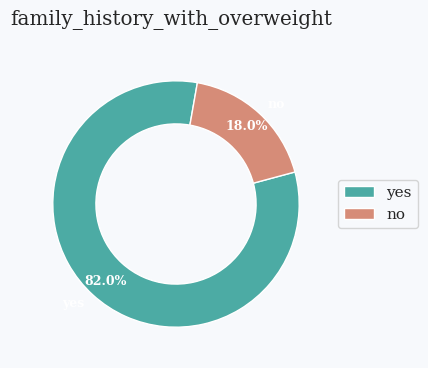

In [13]:
showplot("family_history_with_overweight")

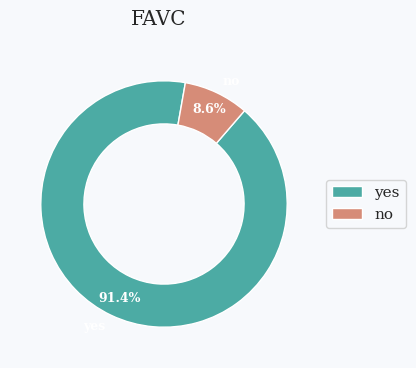

In [14]:
showplot("FAVC")

### Let's see which type of people use which kind of transportation

In [15]:
import plotly.express as px

In [16]:
cross_tab = pd.crosstab(df_train.NObeyesdad, df_train.MTRANS)

In [17]:
count = df_train.groupby(["NObeyesdad", "MTRANS"], as_index=False).count()

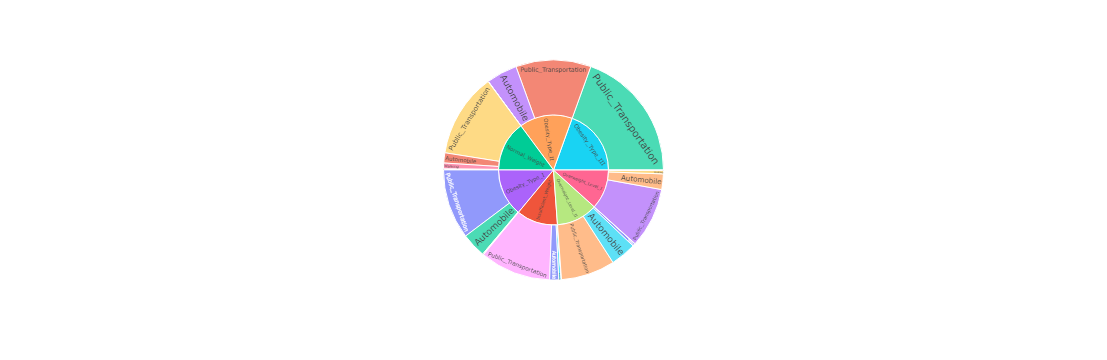

In [18]:
fig = px.sunburst(count, path=['NObeyesdad', 'MTRANS'], values='id',
                  color='id', hover_data=['id'],
                  color_continuous_scale='RdBu')
fig.show()

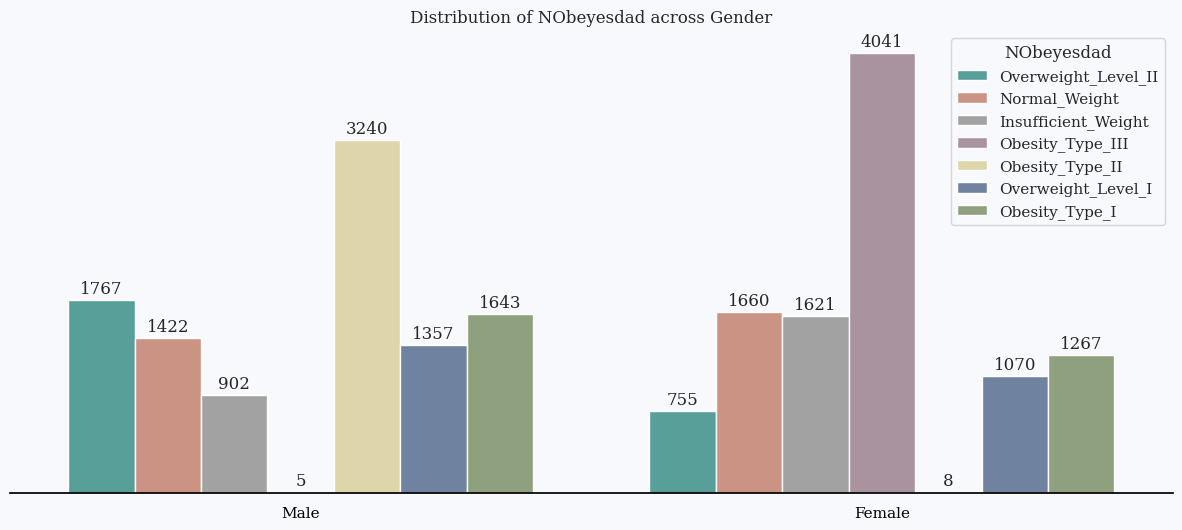

In [19]:
plt.figure(figsize=(15, 6))
ax = sns.countplot(x='Gender', hue='NObeyesdad', data=df_train, palette=colors, dodge=True)
plt.title('Distribution of NObeyesdad across Gender')
sns.despine(left=True, bottom=False)
plt.xlabel('')
plt.ylabel('')
plt.yticks([])
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{round(height)}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 8), textcoords='offset points')
plt.show()

## Let's Build the model with the help of lgbmclassifier

## Got the trained parameters for the dataframe

In [6]:
best_params = {
    "objective": "multiclass",          # Objective function for the model
    "metric": "multi_logloss",          # Evaluation metric
    "verbosity": -1,                    # Verbosity level (-1 for silent)
    "boosting_type": "gbdt",            # Gradient boosting type
    "random_state": 42,       # Random state for reproducibility
    "num_class": 7,                     # Number of classes in the dataset
    'learning_rate': 0.030962211546832760,  # Learning rate for gradient boosting
    'n_estimators': 500,                # Number of boosting iterations
    'lambda_l1': 0.009667446568254372,  # L1 regularization term
    'lambda_l2': 0.04018641437301800,   # L2 regularization term
    'max_depth': 10,                    # Maximum depth of the trees
    'colsample_bytree': 0.40977129346872643,  # Fraction of features to consider for each tree
    'subsample': 0.9535797422450176,    # Fraction of samples to consider for each boosting iteration
    'min_child_samples': 26             # Minimum number of data needed in a leaf
}

In [7]:
from lightgbm import LGBMClassifier

C:\Users\abhis\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


## Extracting variable types

In [5]:
def extract_varaible_types(df):
    catagorical_col = []
    continious_col = []
    for col in df.columns:
        if df[col].dtype == "object":
            catagorical_col.append(col)
        else:
            continious_col.append(col)

    return catagorical_col, continious_col

In [6]:
categorical_vars, continuous_vars = extract_varaible_types(df_train)
continuous_vars.remove('id'), categorical_vars.remove('NObeyesdad')

print("Continuous Variables:", continuous_vars)
print("Categorical Variables:", categorical_vars)

Continuous Variables: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Categorical Variables: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


In [49]:
def plot_distribution(dataframe, target_column):
    # Calculate value counts
    value_counts = dataframe[target_column].value_counts()

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Bar plot on the first subplot
    sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis", ax=ax1)
    ax1.set_xlabel(target_column, fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=10)

    # Add data labels above each bar
    for index, value in enumerate(value_counts):
        ax1.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

    # Pie plot on the second subplot
    ax2.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=sns.color_palette("viridis", len(value_counts)))
    ax2.axis('equal')

    # Main title for the figure
    fig.suptitle(f'Comparison of {target_column} Distribution in the Dataset', fontsize=18)
    
    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

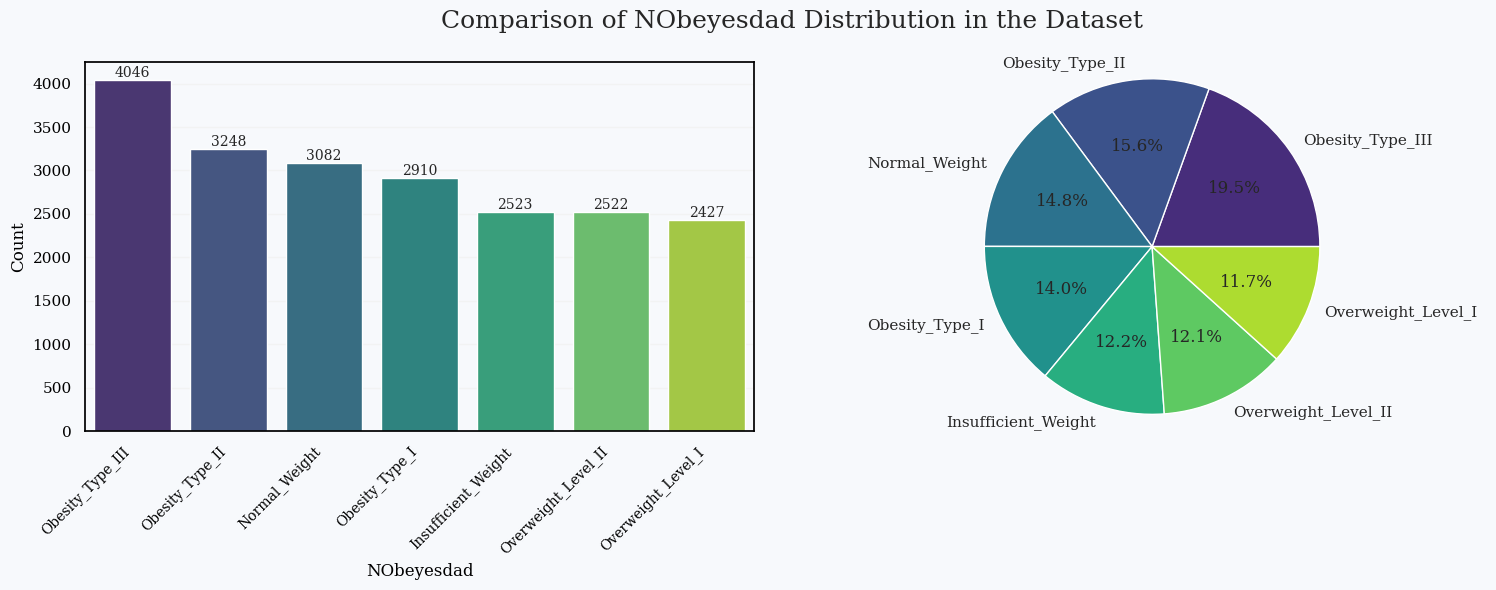

In [50]:
plot_distribution(df_train, "NObeyesdad"

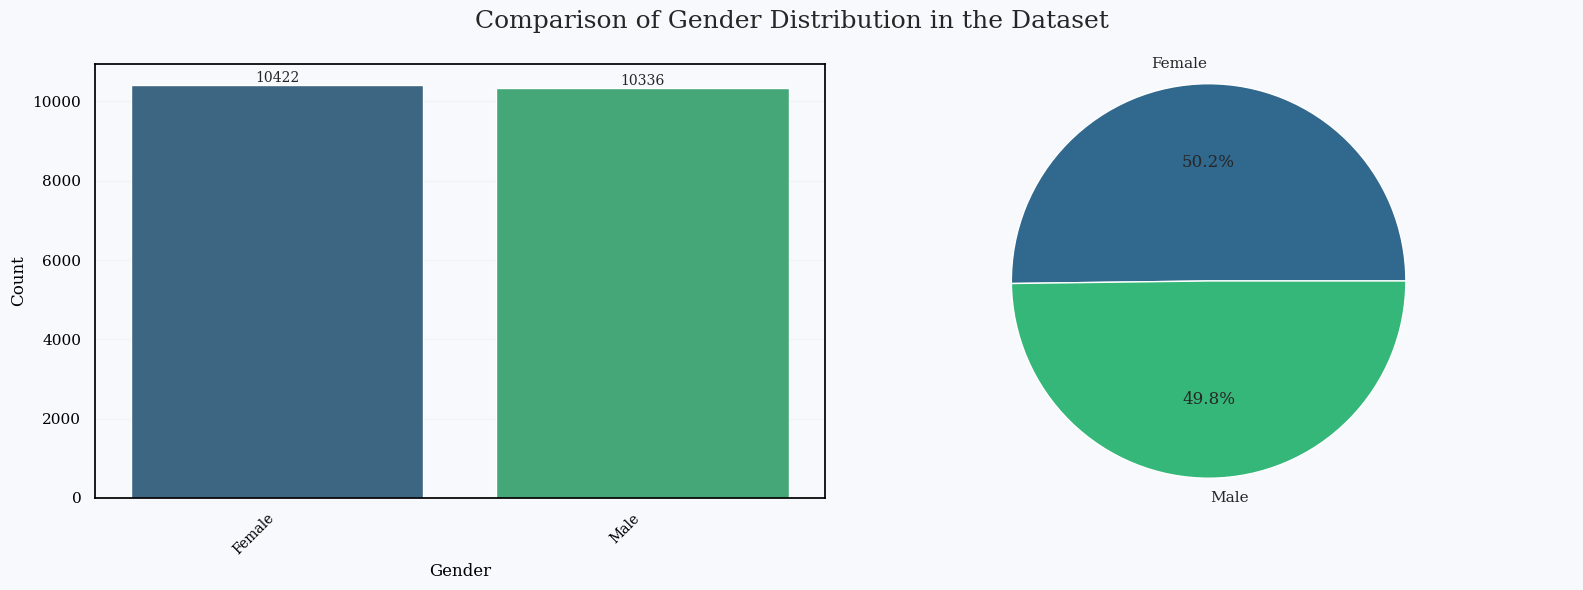

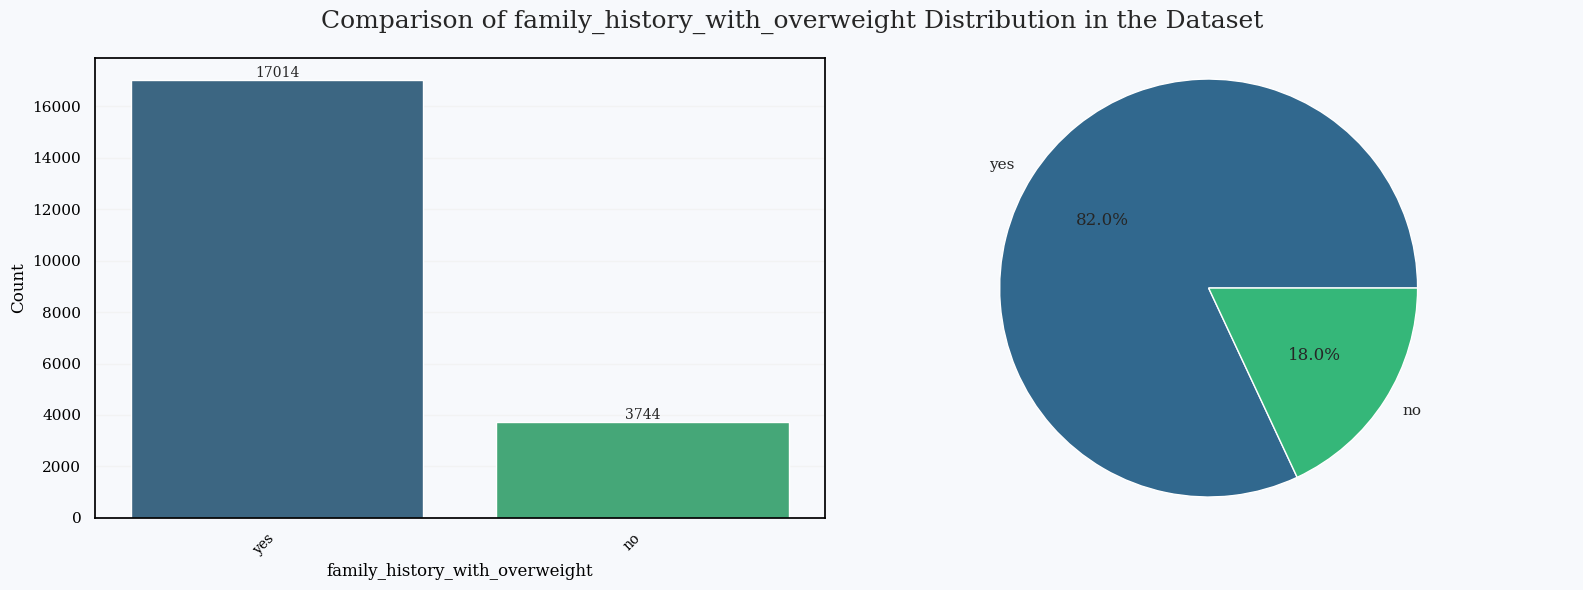

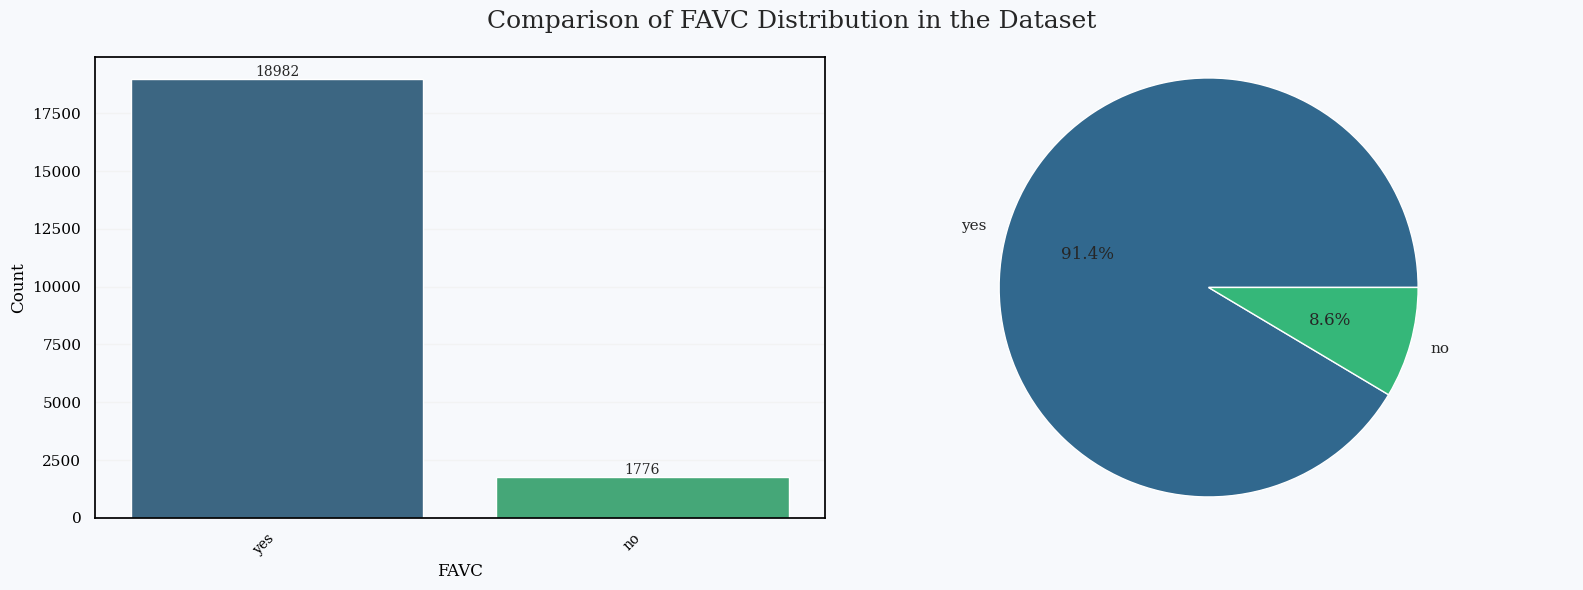

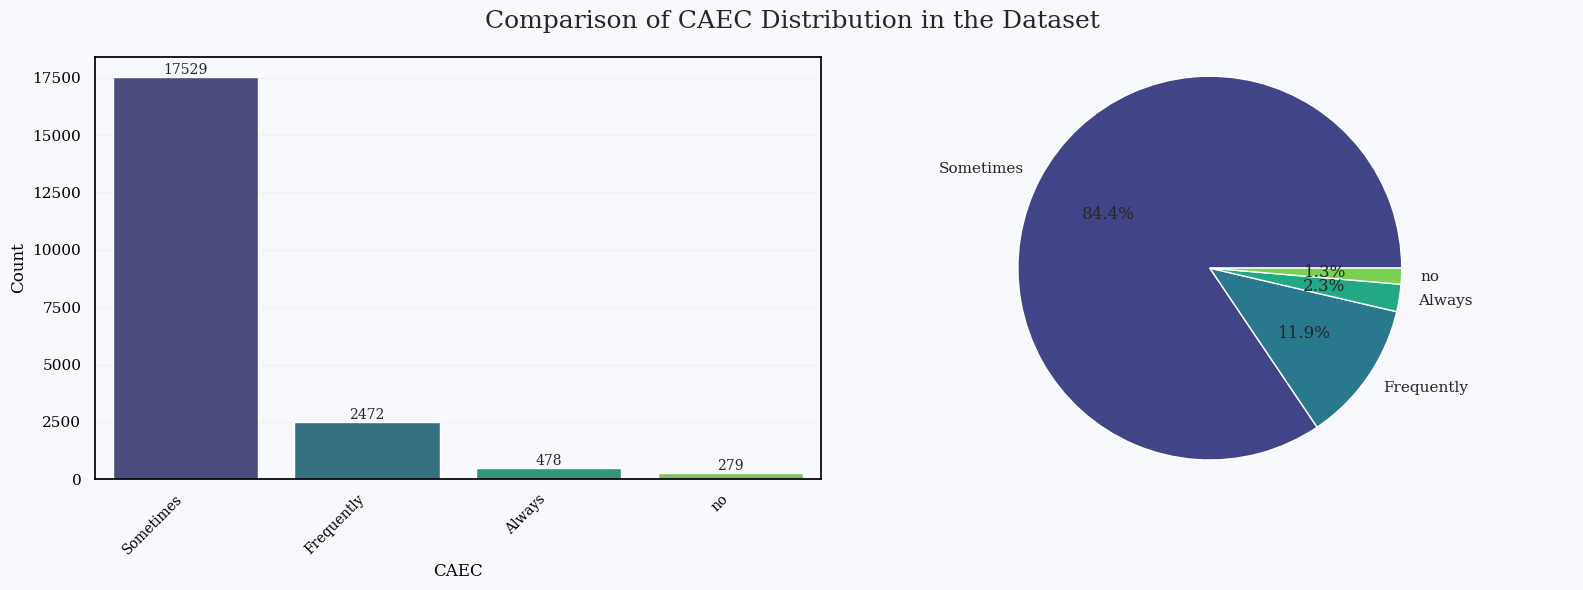

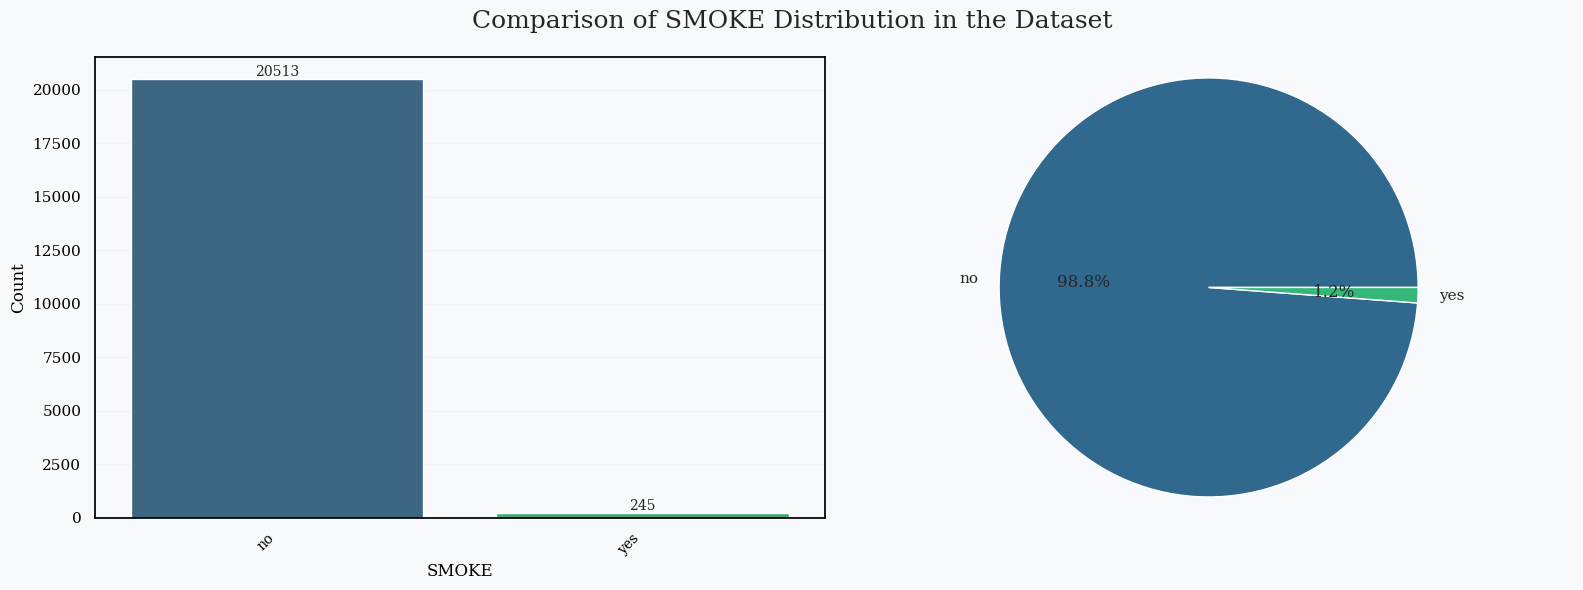

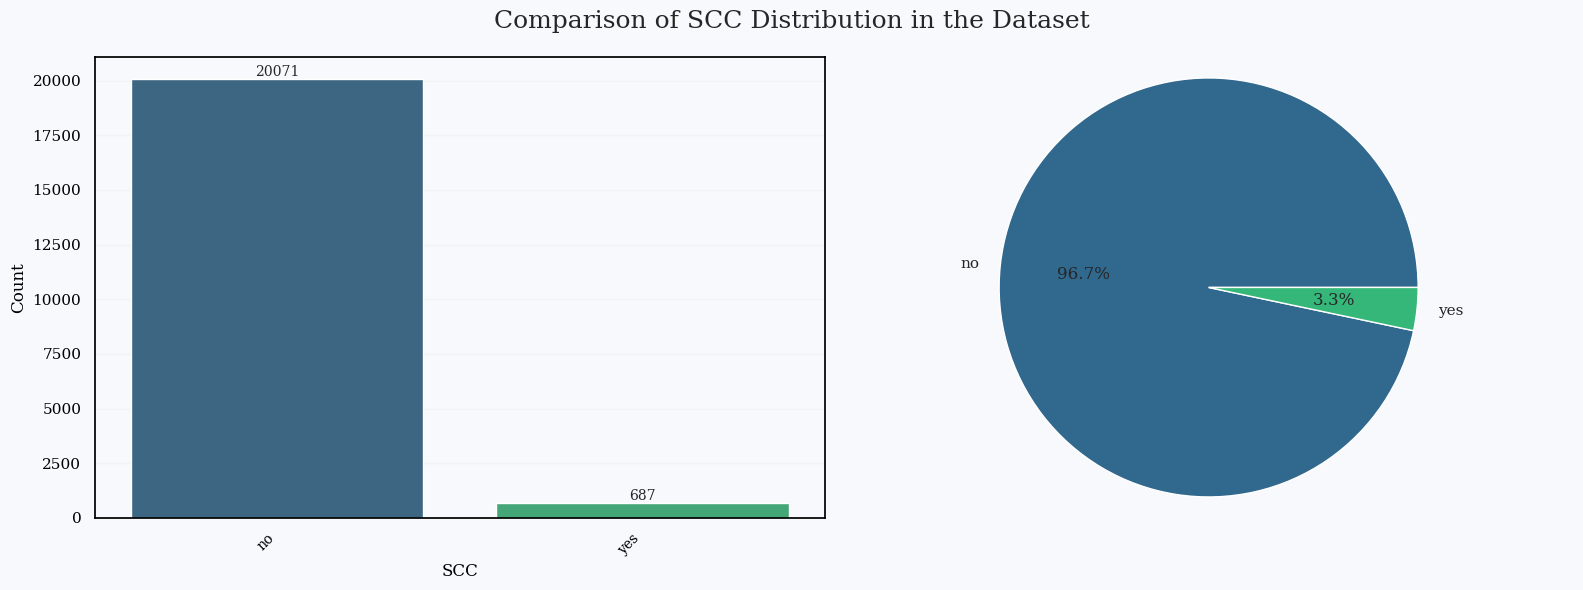

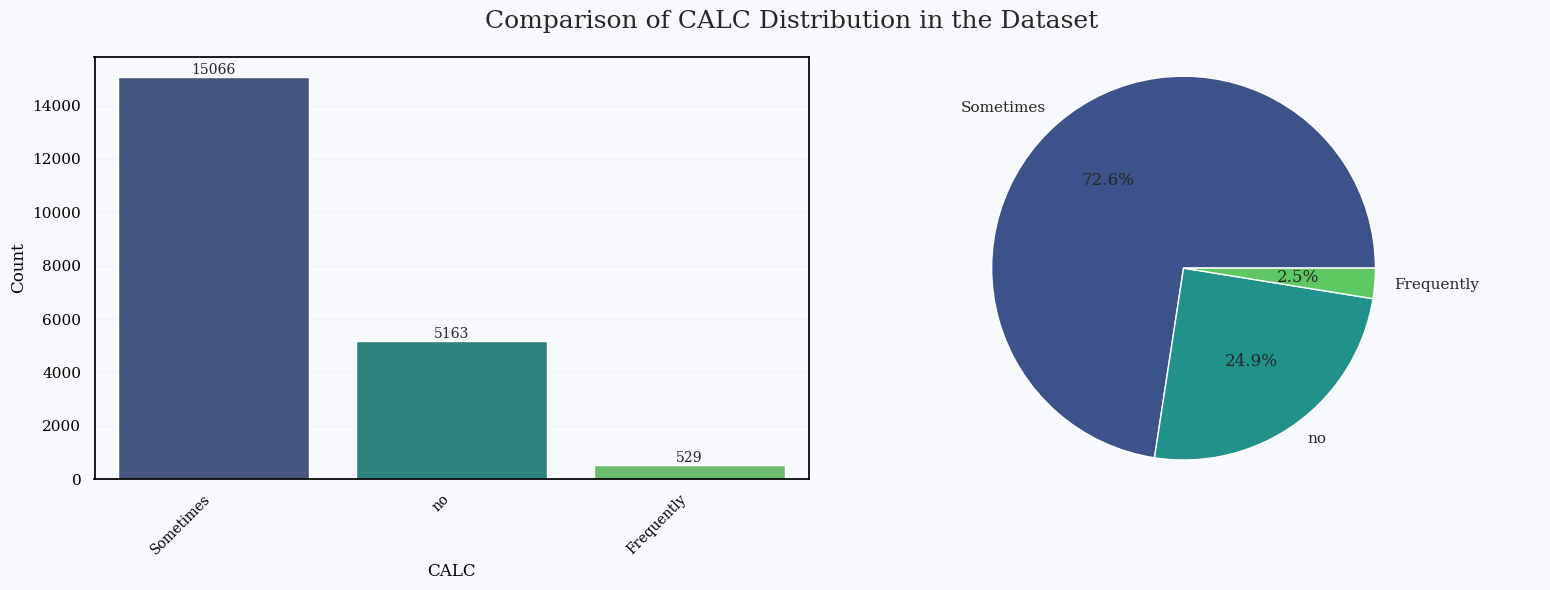

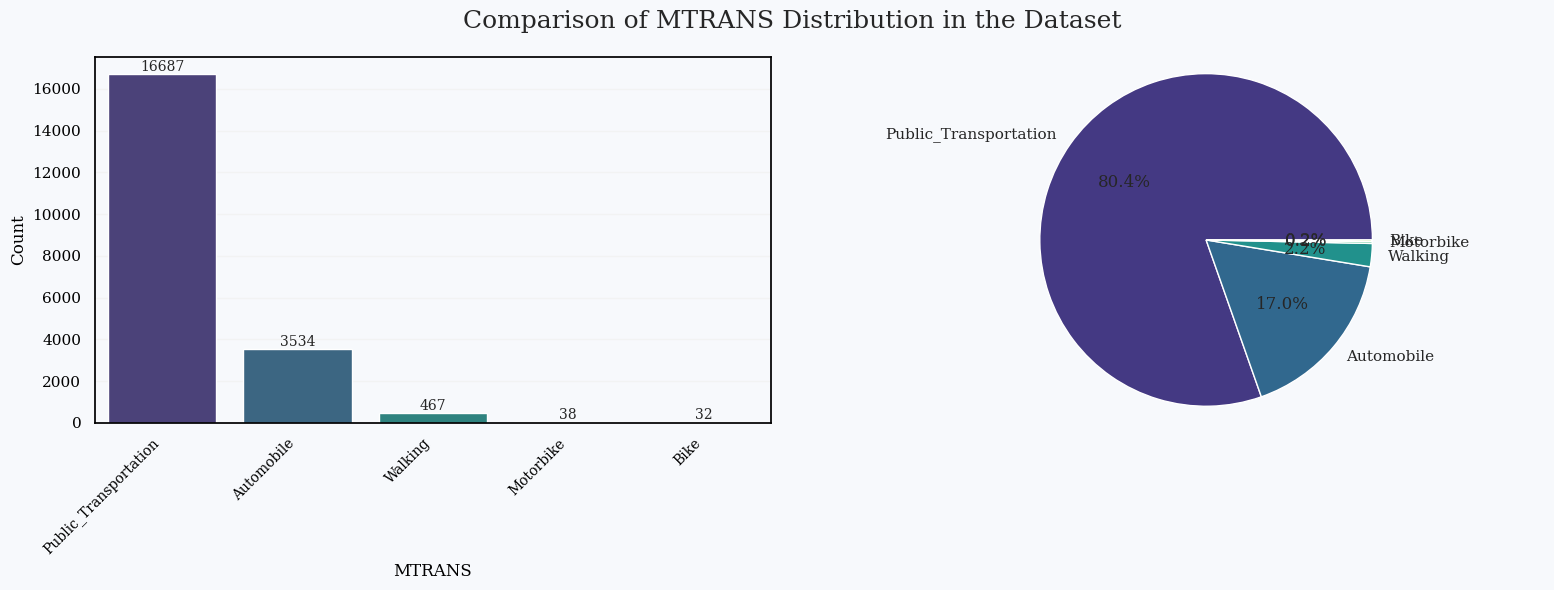

In [51]:
# fig, axs = plt.subplots(len(categorical_vars), 2, figsize=(16, 6))
# axs = axs.flatten()

for cat in categorical_vars:
    plot_distribution(df_train, cat)

## Plotting histograms and density plots for Continious variables

In [59]:
def plot_continious(df, col):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    sns.histplot(
        data=df, x=col, hue="NObeyesdad", bins=50, kde=True, ax=ax
    )
    ax.set_ylim(0, 500)
    plt.tight_layout()
    plt.show()

C:\Users\abhis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



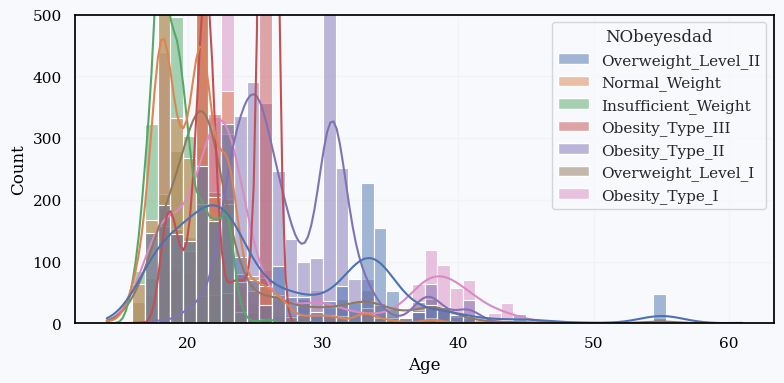

C:\Users\abhis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



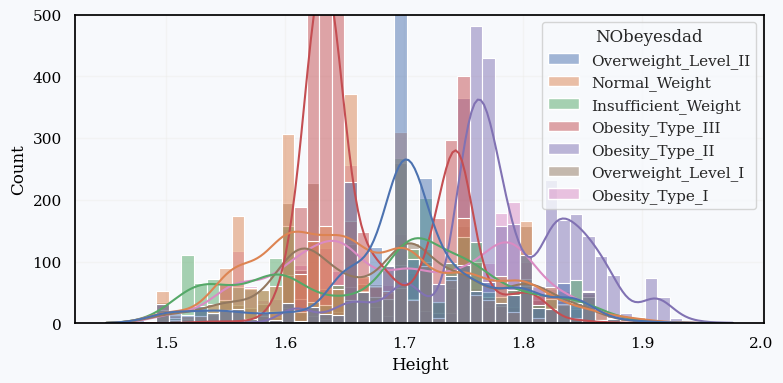

C:\Users\abhis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



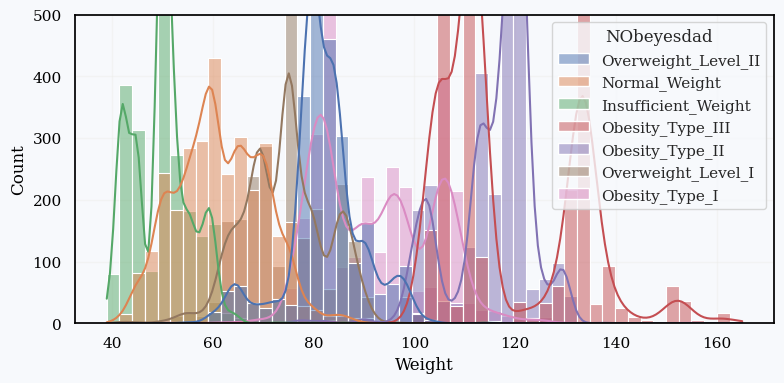

C:\Users\abhis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



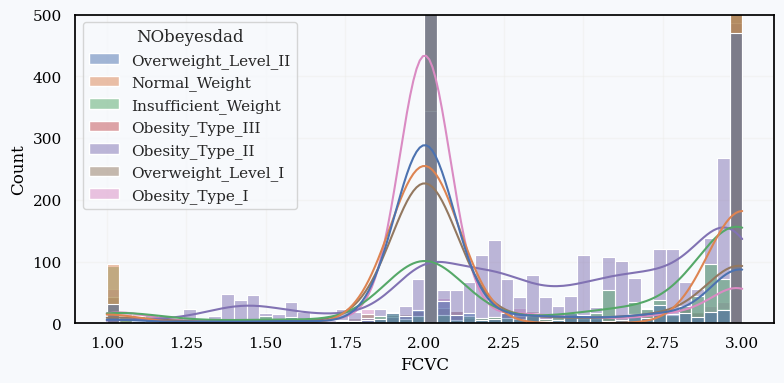

C:\Users\abhis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



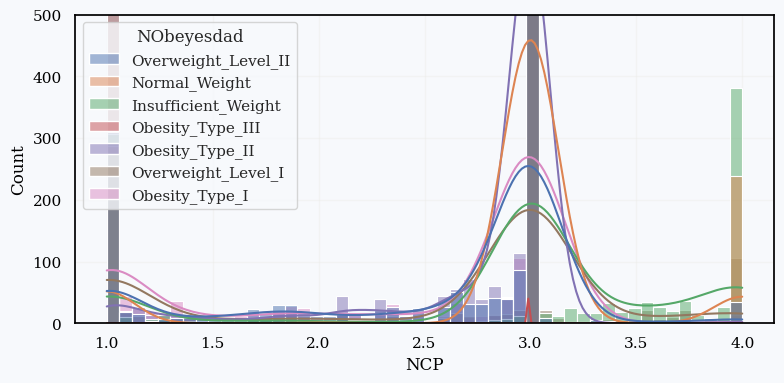

C:\Users\abhis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



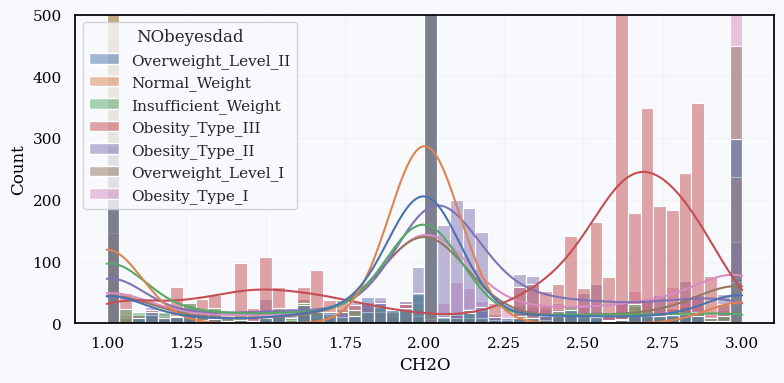

C:\Users\abhis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



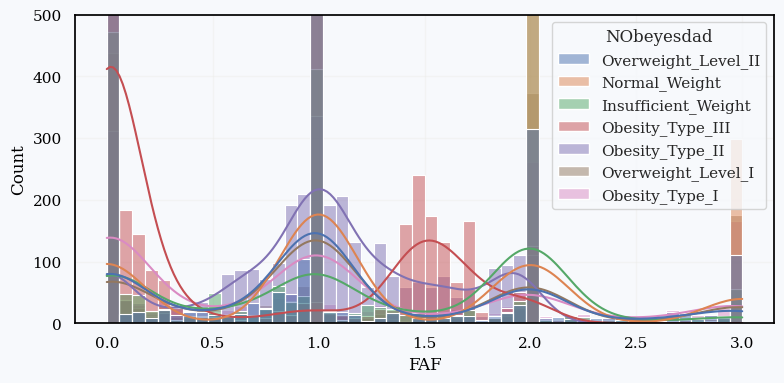

C:\Users\abhis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



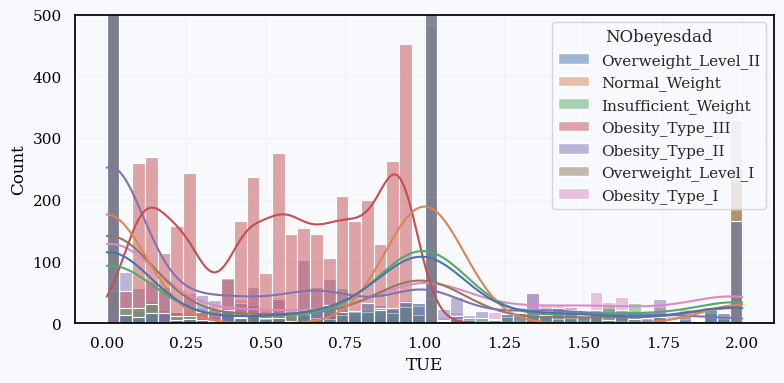

In [60]:
for cat in continuous_vars:
    plot_continious(df_train, cat)

In [7]:
train = df_train.drop(["id", "NObeyesdad"], axis=1)
y = df_train["NObeyesdad"].astype("category")
test = df_test.drop(['id'], axis=1)

# One-Hot Encoding Categorical Variables in Training and Test Data

In [11]:
train = pd.get_dummies(train,
                       columns=categorical_vars)
test = pd.get_dummies(test, 
                      columns=categorical_vars)
train.head()

Age  Height  Weight  FCVC  NCP  CH2O  FAF  TUE  Gender_Female  \
0 24.44    1.70   81.67  2.00 2.98  2.76 0.00 0.98          False   
1 18.00    1.56   57.00  2.00 3.00  2.00 1.00 1.00           True   
2 18.00    1.71   50.17  1.88 1.41  1.91 0.87 1.67           True   
3 20.95    1.71  131.27  3.00 3.00  1.67 1.47 0.78           True   
4 31.64    1.91   93.80  2.68 1.97  1.98 1.97 0.93          False   

   Gender_Male  family_history_with_overweight_no  \
0         True                              False   
1        False                              False   
2        False                              False   
3        False                              False   
4         True                              False   

   family_history_with_overweight_yes  FAVC_no  FAVC_yes  CAEC_Always  \
0                                True    False      True        False   
1                                True    False      True        False   
2                                True    False      True        False   
3                                True    False      True        False   
4                                True    False      True        False   

   CAEC_Frequently  CAEC_Sometimes  CAEC_no  SMOKE_no  SMOKE_yes  SCC_no  \
0            False            True    False      True      False    True   
1             True           False    False      True      False    True   
2            False            True    False      True      False    True   
3            False            True    False      True      False    True   
4            False            True    False      True      False    True   

   SCC_yes  CALC_Frequently  CALC_Sometimes  CALC_no  MTRANS_Automobile  \
0    False            False            True    False              False   
1    False            False           False     True               True   
2    False            False           False     True              False   
3    False            False            True    False              False   
4    False            False            True    False              False   

   MTRANS_Bike  MTRANS_Motorbike  MTRANS_Public_Transportation  MTRANS_Walking  
0        False             False                          True           False  
1        False             False                         False           False  
2        False             False                          True           False  
3        False             False                          True           False  
4        False             False                          True           False

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (16606, 30)
X_test shape: (4152, 30)
y_train shape: (16606,)
y_test shape: (4152,)


In [13]:
# %pip install optuna
from optuna.samplers import TPESampler
import optuna

In [73]:
# #The tuning process has been commented out due to its time-consuming nature.

# # Define the objective function for Optuna optimization
def objective(trial, X_train, y_train, X_test, y_test):
    # Define parameters to be optimized for the LGBMClassifier
    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        "num_class": 7,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
        "n_estimators": trial.suggest_int("n_estimators", 400, 600),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.015),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
        "max_depth": trial.suggest_int("max_depth", 6, 14),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
    }

    # Create an instance of LGBMClassifier with the suggested parameters
    lgbm_classifier = LGBMClassifier(**param)
    
    # Fit the classifier on the training data
    lgbm_classifier.fit(X_train, y_train)

    # Evaluate the classifier on the test data
    score = lgbm_classifier.score(X_test, y_test)

    return score

# Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Adjust the test_size as needed

# Set up the sampler for Optuna optimization
sampler = optuna.samplers.TPESampler(seed=42)  # Using Tree-structured Parzen Estimator sampler for optimization

# Create a study object for Optuna optimization
study = optuna.create_study(direction="maximize", sampler=sampler)

# Run the optimization process
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=100)

# Get the best parameters after optimization
best_params = study.best_params

print('='*50)
print(best_params)

[I 2024-02-12 20:19:11,940] A new study created in memory with name: no-name-0e0f7e83-c4fc-49d1-a101-ef6d79dc66c9
[I 2024-02-12 20:19:17,602] Trial 0 finished with value: 0.9058285163776493 and parameters: {'learning_rate': 0.0249816047538945, 'n_estimators': 591, 'lambda_l1': 0.012319939418114049, 'lambda_l2': 0.04394633936788146, 'max_depth': 7, 'colsample_bytree': 0.3935967122017216, 'subsample': 0.8116167224336399, 'min_child_samples': 45}. Best is trial 0 with value: 0.9058285163776493.
[I 2024-02-12 20:19:23,039] Trial 1 finished with value: 0.9058285163776493 and parameters: {'learning_rate': 0.034044600469728355, 'n_estimators': 542, 'lambda_l1': 0.005205844942958024, 'lambda_l2': 0.05879639408647977, 'max_depth': 13, 'colsample_bytree': 0.4274034664069657, 'subsample': 0.8363649934414201, 'min_child_samples': 17}. Best is trial 0 with value: 0.9058285163776493.
[I 2024-02-12 20:19:26,962] Trial 2 finished with value: 0.9070327552986512 and parameters: {'learning_rate': 0.02216

KeyboardInterrupt: 

In [14]:
med_params = {
    "objective": "multiclass",          # Objective function for the model
    "metric": "multi_logloss",          # Evaluation metric
    "verbosity": -1,                    # Verbosity level (-1 for silent)
    "boosting_type": "gbdt",            # Gradient boosting type
    "random_state": 42,       # Random state for reproducibility
    "num_class": 7,
    'learning_rate': 0.01895134294369825, 
    'n_estimators': 466, 
    'lambda_l1': 0.011344769984051855, 
    'lambda_l2': 0.02648255518768994, 'max_depth': 10, 
    'colsample_bytree': 0.5081858432267009, 
    'subsample': 0.8913255843614581, 
    'min_child_samples': 22
}

In [17]:
lgbm_classifier = LGBMClassifier(**med_params)
lgbm_classifier.fit(X_train, y_train)
y_pred = lgbm_classifier.predict(X_test)
accuracy_score(y_pred, y_test)

0.9072736030828517

In [8]:
test.drop("CALC_Always", axis=1, inplace=True)

KeyError: "['CALC_Always'] not found in axis"

In [19]:
predictions = lgbm_classifier.predict(test)

In [20]:
new_df = pd.concat([df_test["id"], pd.Series(predictions)], axis=1)
new_df.drop(index=new_df.index)
new_df.columns = ["id", "NObeyesdad"]
new_df.head()

id          NObeyesdad
0  20758     Obesity_Type_II
1  20759  Overweight_Level_I
2  20760    Obesity_Type_III
3  20761      Obesity_Type_I
4  20762    Obesity_Type_III

In [100]:
new_df.to_csv("submission2.csv")

# XGBoost Approach

In [9]:
X = df_train.drop(["id", "NObeyesdad"], axis=1)
y = df_train["NObeyesdad"]

In [10]:
changed_names = {
    "Obesity_Type_III": 0,
    "Obesity_Type_II": 1,
    "Normal_Weight": 2,
    "Obesity_Type_I": 3,
    "Insufficient_Weight": 4,
    "Overweight_Level_II": 5,
    "Overweight_Level_I": 6,
}

In [11]:
y.replace(changed_names.keys(), changed_names.values(), inplace=True)

In [12]:
# Convert to Pandas category
for col in categorical_vars:
   X[col] = X[col].astype('category')

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
import xgboost as xgb

# Create regression matrices
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [ ]:
# from sklearn.preprocessing import OrdinalEncoder

# X, y = diamonds.drop("cut", axis=1), diamonds[['cut']]

# # Encode y to numeric
# y_encoded = OrdinalEncoder().fit_transform(y)

# # Extract text features
# cats = X.select_dtypes(exclude=np.number).columns.tolist()

# # Convert to pd.Categorical
# for col in cats:
#    X[col] = X[col].astype('category')

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=1, stratify=y_encoded)

In [15]:
params = {"objective": "multi:softprob", "tree_method": "hist", "num_class": 7}
n = 1000

# results = xgb.cv(
#    params, dtrain_clf,
#    num_boost_round=n,
#    nfold=5,
#    metrics=["mlogloss", "auc", "merror"],
# )

In [30]:
# results.keys()

In [31]:
# results['test-auc-mean'].max()

In [16]:
final_model = xgb.train(params, dtrain_clf, num_boost_round=200)

In [24]:
predictions = final_model.predict(dtest)

# If you want to get the class with the highest probability for each sample
predicted_classes = predictions.argmax(axis=1).tolist()

In [25]:
pred = []
for i in predicted_classes:
    pred.append(list(changed_names.keys())[list(changed_names.values()).index(i)])

In [26]:
y_train_new = []
for i in y_test:
    y_train_new.append(list(changed_names.keys())[list(changed_names.values()).index(i)])

In [20]:
accuracy_score(pred, y_train_new)

0.9024566473988439

In [29]:
new_df = pd.concat([df_test["id"], pd.Series(pred)], axis=1)
new_df.drop(index=new_df.index)
new_df.columns = ["id", "NObeyesdad"]
new_df.shape

(13840, 2)

In [30]:
new_df.to_csv("submission3.csv")

In [21]:
for col in categorical_vars:
   test[col] = test[col].astype('category')

In [23]:
dtest = xgb.DMatrix(test, enable_categorical=True)